In [1]:
from glob import glob
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from os.path import join

In [2]:
ORIGINAL_SIZE = (1280, 720)
pickle_root = 'pickle_files/'
CALIB_FILE_NAME = pickle_root + 'calib_file'
PERSPECTIVE_FILE_NAME = pickle_root + 'perspective_file2.p'

fopen = pickle.load(open(PERSPECTIVE_FILE_NAME, "rb"))
pixels_per_meter = fopen['pixels_per_meter']
print('perspective: {:4.2f} pix/m x dimention, {:4.2f} pix/m y dimention'.format(
    pixels_per_meter[0], pixels_per_meter[1]))

src = fopen['orig_points']
dst = fopen['dst_points']

fopen = pickle.load(open(CALIB_FILE_NAME, "rb"))
mtx = fopen['cam_matrix']
dist = fopen['dist_coeffs']

m = cv2.getPerspectiveTransform(src, dst)

perspective: 231.76 pix/m x dimention, 17.12 pix/m y dimention


In [3]:
def undistort(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp(img, m=m, wout=ORIGINAL_SIZE):   
    return cv2.warpPerspective(img, m, wout, flags=cv2.INTER_LINEAR)

def unwarp(img, m=m, wout=ORIGINAL_SIZE):
    return cv2.warpPerspective(img, m, wout, flags=cv2.WARP_FILL_OUTLIERS +
                                                                 cv2.INTER_CUBIC+cv2.WARP_INVERSE_MAP)
def draw_trap(image, points=src):
    with_trap = np.copy(image)
    cv2.polylines(with_trap,[np.array(points, dtype=np.int32)],True,(0,0,255), thickness=5)
    return with_trap
    
def img_transform(img_path, src, dst=dst):
    image = plt.imread(img_path)
    undist = undistort(image)
    with_trap = draw_trap(undist)   
    wout = (image.shape[1], image.shape[0])
    m = cv2.getPerspectiveTransform(src, dst)
    from_top = cv2.warpPerspective(undist, m, wout, flags=cv2.INTER_LINEAR)
    return image, undist, with_trap, from_top

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.recent_fits = []
        self.recent_curves = []
        self.line_found_in_last_frame = True
        self.avg_fit = []
        self.avg_curve = 0
        self.has_avgs = False
        
    def append_fit(self, x, n=5):
        self.recent_fits.append(x)
        if len(self.recent_fits) > n:
            self.recent_fits.pop(0)
        self.avg_fit = np.mean(self.recent_fits, axis=0)
        self.has_avgs = True
    
    def append_curve(self, x, n=4):
        self.recent_curves.append(x)
        if len(self.recent_curves) > n:
            self.recent_curves.pop(0)
        self.avg_curve = np.average(self.recent_curves)
    
    def get_avgs(self):
        return self.avg_fit, self.avg_curve
    
    def found_lane(self, x):
        if not x:
            if self.line_found_in_last_frame:
                self.line_found_in_last_frame = False
            else:
                self.recent_fits = []
                self.recent_curves = []
                self.has_avgs = False
        else:
            self.line_found_in_last_frame = True
            

class Car_location():
    def __init__(self):
        self.recent_position = []
        self.avg_shift = 0
    
    def append_pix_shift(self, x, n=3):
        self.recent_position.append(x)
        if len(self.recent_position) > n:
            self.recent_position.pop(0)
        self.avg_shift = np.average(self.recent_position)

In [5]:
def plot_trans(img, pts=src):
    image, undist, with_trap, from_top = img_transform(img, pts)
    plt.clf()
    f, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('image', fontsize=20)
    ax2.imshow(undist)
    ax2.set_title('undistort', fontsize=20)
    ax3.imshow(with_trap)
    ax3.set_title('with_trap', fontsize=20)
    ax4.imshow(from_top)
    ax4.set_title('from_top', fontsize=20)
    plt.show()

6 test images in path


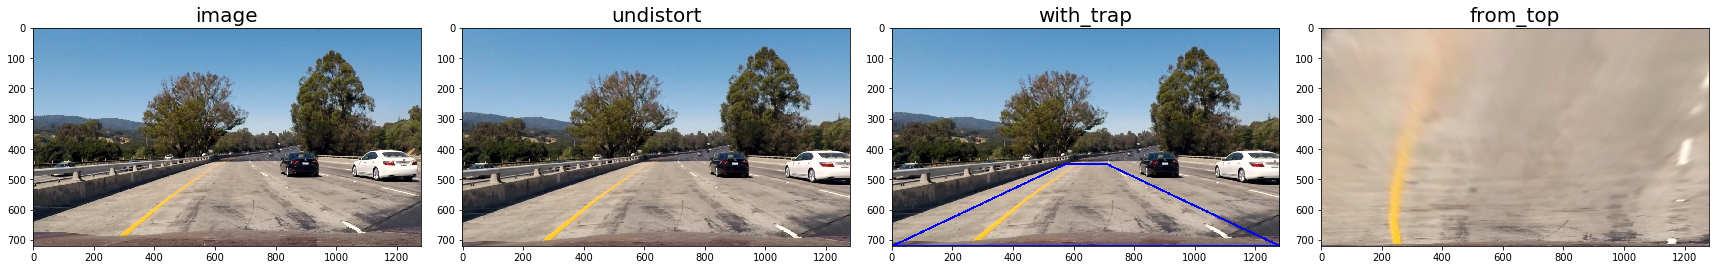

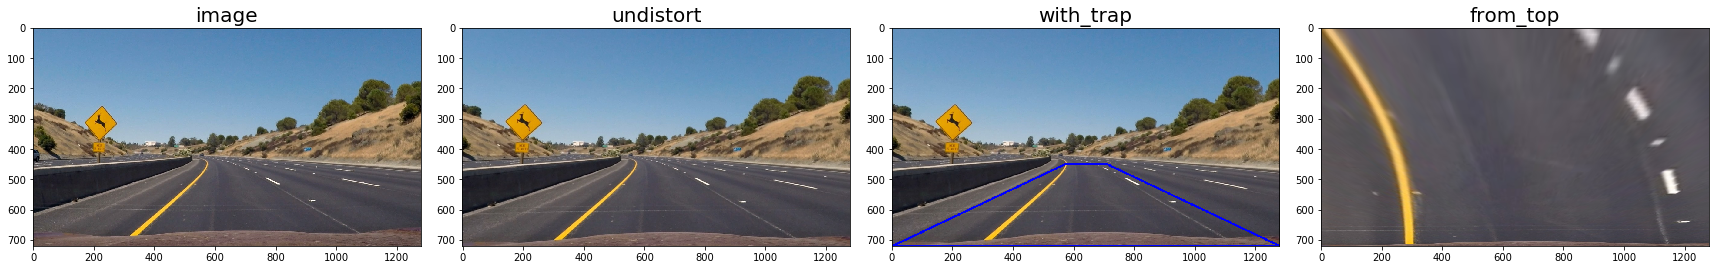

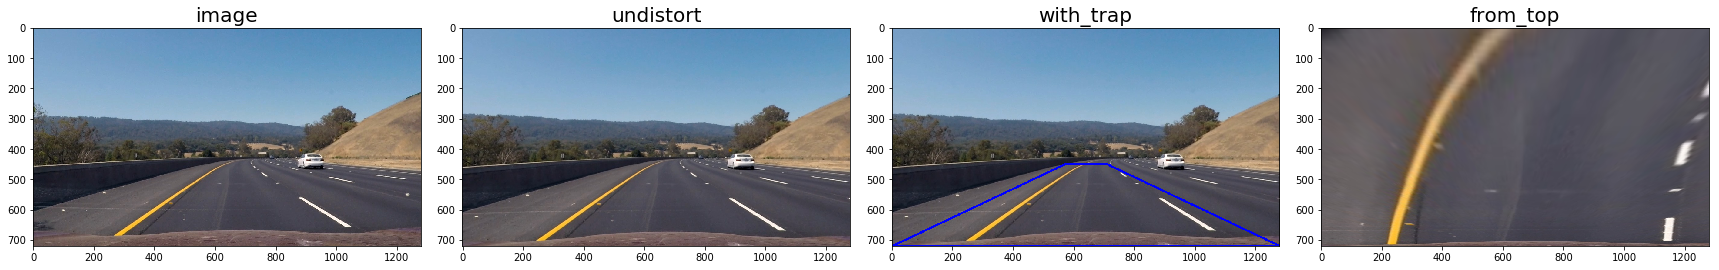

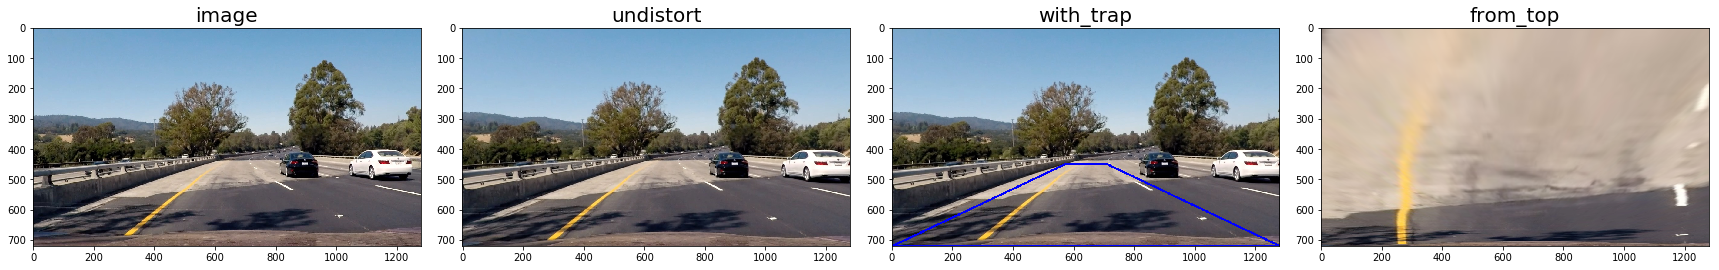

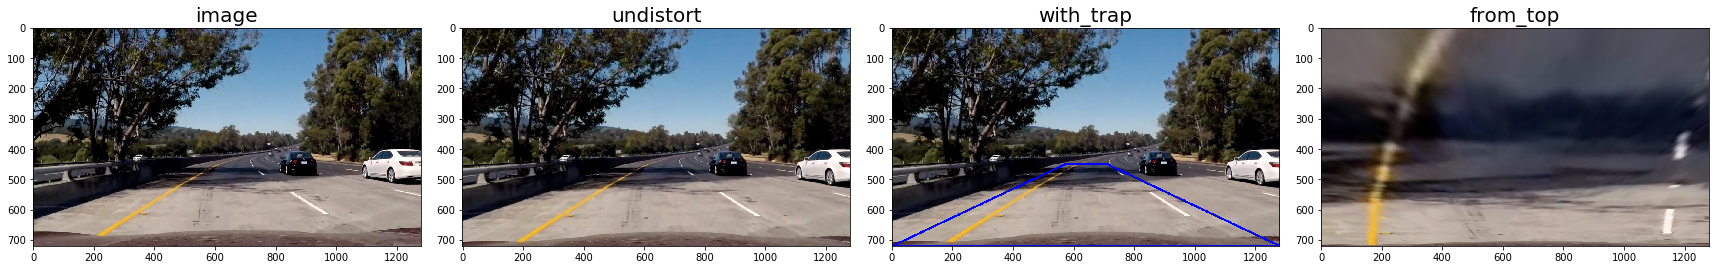

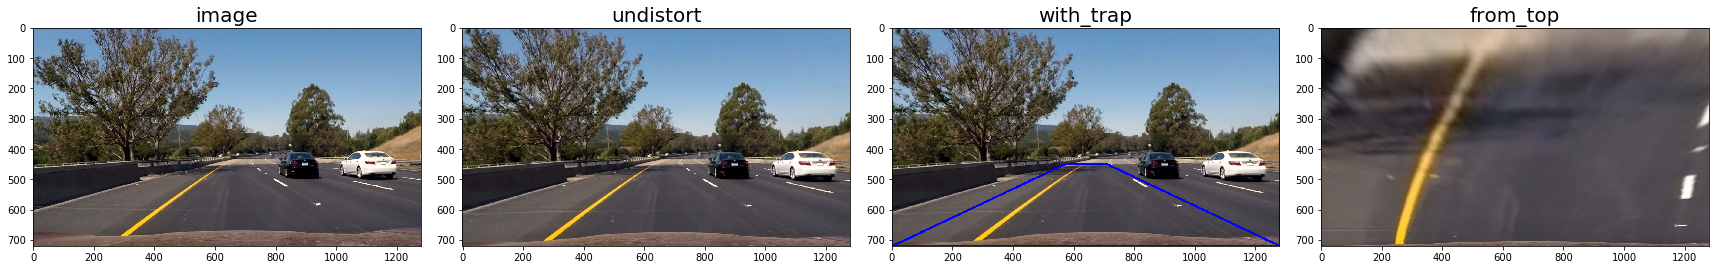

In [6]:
test_fnames = glob('test_images/test*.jpg')
print(len(test_fnames), 'test images in path')

for image in test_fnames:
    plot_trans(image)

In [7]:
def apply_mask(img, roi):
    mask = np.zeros_like(img)  
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        ignore_mask_color = (255,) * img.shape[2]
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, roi, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def enhance_lines(img, s_thresh=(170, 255), sx_thresh=(20, 90), h_thresh=(15,100)): 
    test_img = undistort(img)
    img_hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
    img_hls = cv2.medianBlur(img_hls, 5).astype(np.float)
    h_channel = img_hls[:,:,0]
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    hs_binary = np.zeros_like(h_channel)
    hs_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) & (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    gray_binary = np.zeros_like(sxbinary)
    gray_binary[(sxbinary==1) | (hs_binary == 1)] = 1
    
#     print('enhance_lines out shape:', gray_binary.shape)
    return gray_binary, test_img

In [9]:
def get_poly_fit_and_curve(y, x, shape, pixels_per_meter=pixels_per_meter):
    ym_per_pix = 1/pixels_per_meter[1]
    xm_per_pix = 1/pixels_per_meter[0]
    ploty = np.linspace(0, shape[0]-1, shape[0])
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to each
    if len(y) > 0:
        fit = np.polyfit(y, x, 2)
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    else:
        fit, curverad = [], 0
        
    return fit, curverad


def update_line(line, fit, curverad):
    if curverad != 0:
        line.append_fit(fit)
        line.append_curve(curverad)
        line.found_lane(True)
    else:
        line.found_lane(False)


# Take a histogram of the bottom half of the image
def find_lanes(img, real_world=True):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    if len(img.shape) < 3:
        out_img = np.dstack((img, img, img))*255
    else:
        out_img = np.copy(img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, left_curverad = get_poly_fit_and_curve(lefty, leftx, img.shape)
    right_fit, right_curverad = get_poly_fit_and_curve(righty, rightx, img.shape)
    
    if real_world:
        update_line(detected_left_line, left_fit, left_curverad)
        update_line(detected_right_line, right_fit, right_curverad)
    else:
        return left_fit, right_fit, left_curverad, right_curverad

In [10]:
def car_shift_txt(pix_shift):
    if pix_shift < 0:
        position = 'left'
    else:
        position = 'right'
    car_pos_txt = "Car is {:4.2f}m {} of mid-lane".format(abs(pix_shift/pixels_per_meter[0]), position)
    return car_pos_txt


def get_car_shift(img, left_fit, right_fit, vid_process=True): 
    car_loc = img.shape[0]
    mid_lane = (left_fit[0]*car_loc**2+left_fit[1]*car_loc+left_fit[2]+
                right_fit[0]*car_loc**2+right_fit[1]*car_loc+right_fit[2])/2
    shift = img.shape[1]/2 - mid_lane
    print('car_loc_y:{}, car_loc_x:{}, img.shape[1]/2:{}'.format(car_loc, mid_lane, img.shape[1]/2))
   
    txt = car_shift_txt(shift)
    
    if vid_process:
        car_location.append_pix_shift(-shift*0.25)
    
    return shift, txt

In [11]:
def get_fitx(fit, ploty):
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fitx

def get_line_points(img, fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitx = get_fitx(fit, ploty)
    return np.array([fitx, ploty], dtype=np.int32).T

def add_text_to_image(img, text, pos, color1=(150,150,150), color2=(0,0,0), font_scale=1, thickness=6):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale,
                      thickness=thickness, color=color1)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale,
                      thickness=thickness-2, color=color2)
    return img

def get_curve(left_curv, right_curv):
    lane_curv = 0.5 * (left_curv + right_curv)
    text = "Road curve {:6.1f}m".format(lane_curv)
    return lane_curv, text
    

def add_lines(img, lines): 
    both_lines = np.concatenate((lines[0], np.flipud(lines[1])), axis=0)
    lanes = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.fillPoly(lanes, [both_lines.astype(np.int32)], (0, 255, 0))
    cv2.polylines(lanes, [lines[0].astype(np.int32)], False, (255, 0, 0),thickness=5 )
    cv2.polylines(lanes, [lines[1].astype(np.int32)],False,  (0, 0, 255), thickness=5)
    lanes = unwarp(lanes)
    return lanes

car_loc_y:720, car_loc_x:706.147606176438, img.shape[1]/2:640.0


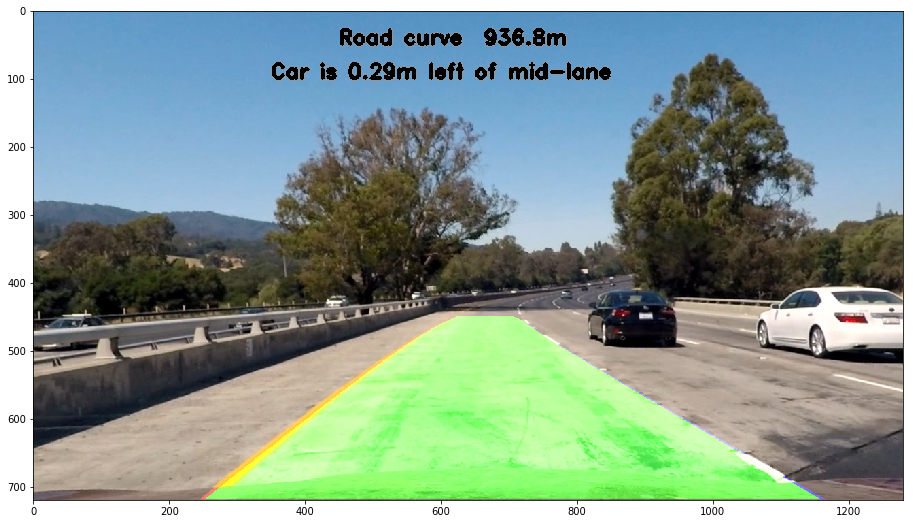

683.2 m 1190.5 m
car_loc_y:720, car_loc_x:721.7735289619291, img.shape[1]/2:640.0


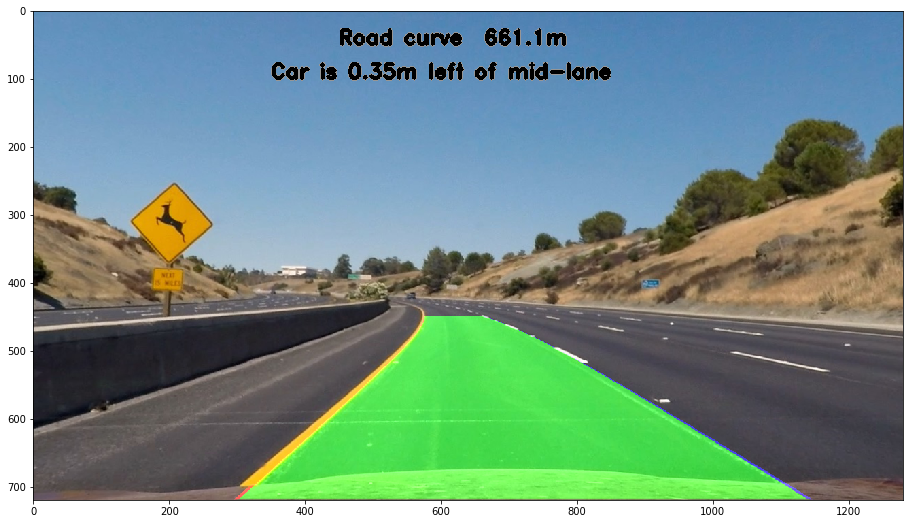

782.9 m 539.4 m
car_loc_y:720, car_loc_x:684.5093413647442, img.shape[1]/2:640.0


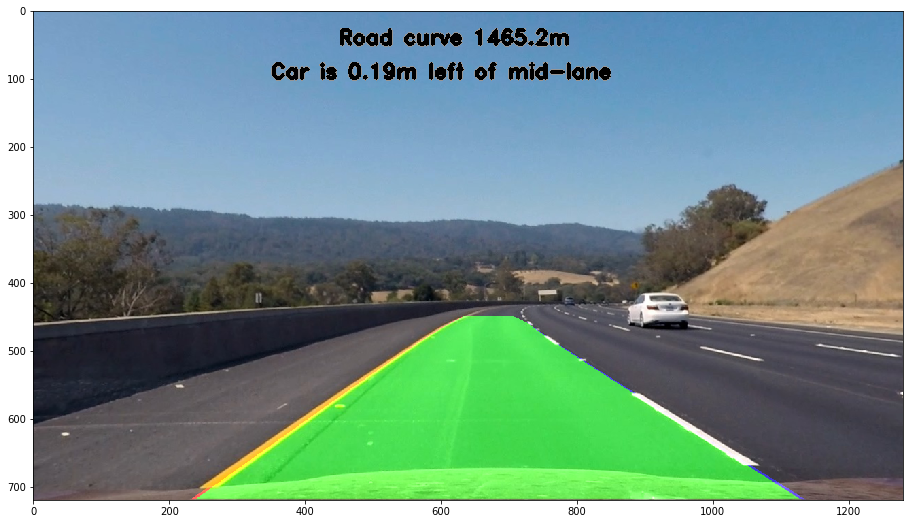

1155.7 m 1774.8 m
car_loc_y:720, car_loc_x:726.7605905890325, img.shape[1]/2:640.0


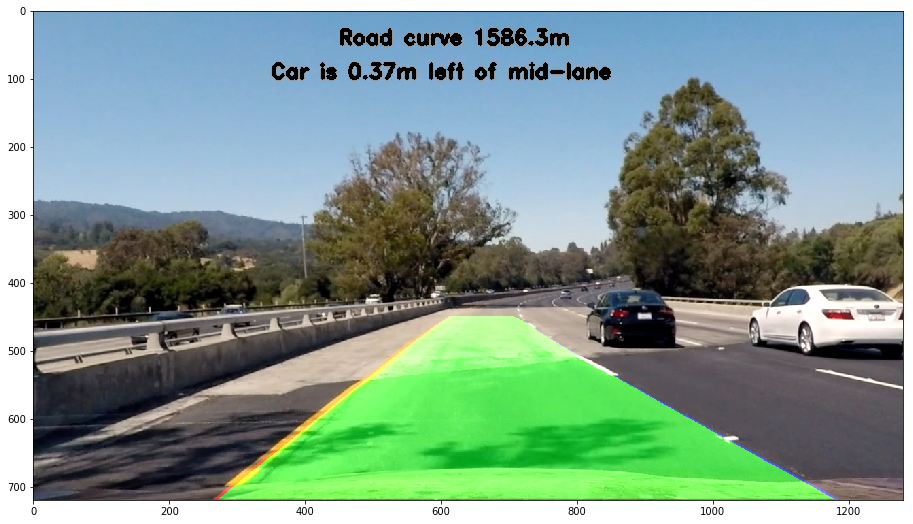

2187.9 m 984.6 m
car_loc_y:720, car_loc_x:649.1529800699426, img.shape[1]/2:640.0


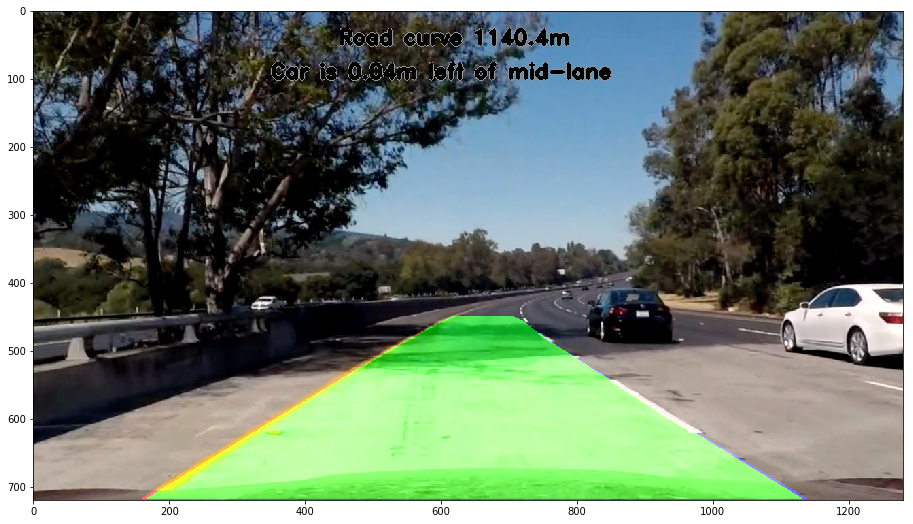

1196.5 m 1084.2 m
car_loc_y:720, car_loc_x:696.9722236591565, img.shape[1]/2:640.0


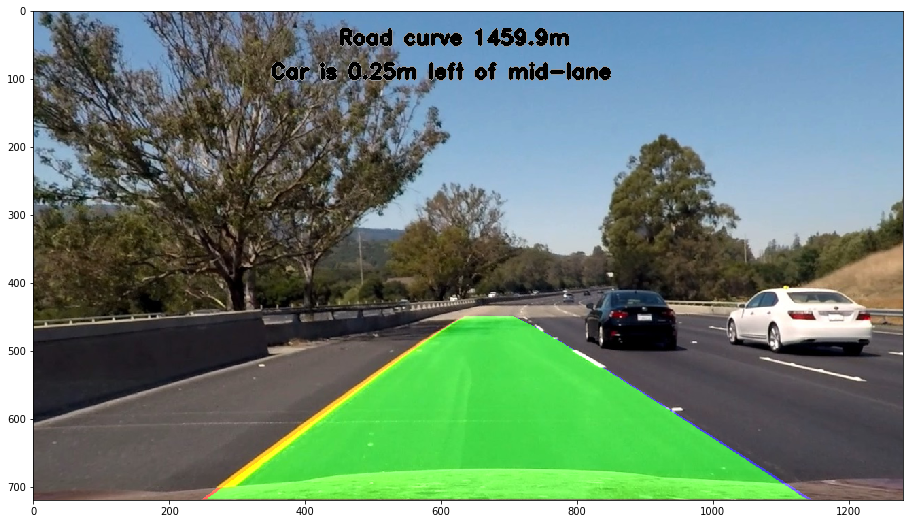

1642.5 m 1277.3 m


In [12]:
for fname in test_fnames:
    
    test_img = plt.imread(fname)
    
    lanes_img, undist = enhance_lines(test_img)
    
    img_from_top = warp(lanes_img)
    
    left_fit, right_fit, left_curv, right_curv = find_lanes(img_from_top, real_world=False)
    
    left_line = get_line_points(test_img, left_fit)
    right_line = get_line_points(test_img, right_fit)
    
    lanes = add_lines(undist, [left_line, right_line])
    
    result = cv2.addWeighted(undist, 1, lanes, 0.6, 0)
    
    pix_shift, car_pos_txt = get_car_shift(undist, left_fit, right_fit, vid_process=False)
        
    lane_curv, road_curv_txt = get_curve(left_curv, right_curv)
    
    result = add_text_to_image(result, car_pos_txt, (350, 100))
    result = add_text_to_image(result, road_curv_txt, (450, 50))
    
    fig = plt.subplots(1, 1, figsize=(24, 9))
    plt.imshow(result)
    plt.show()
    
    print(round(left_curv,1), 'm', round(right_curv,1), 'm')   

In [13]:
def plot_pipline(images, titles):
    plt.clf()
    half = int((len(images)+1)/2)
    
    f, figures = plt.subplots(2, half, figsize=(24, 9))
    print(figures)
    
    for i in range(len(images)):
        if i >= half:
            figures[1, i-half].imshow(images[i])
            figures[1, i-half].set_title(titles[i], fontsize=20)
        else:
            figures[0, i].imshow(images[i])
            figures[0, i].set_title(titles[i], fontsize=20)
        
    plt.show()

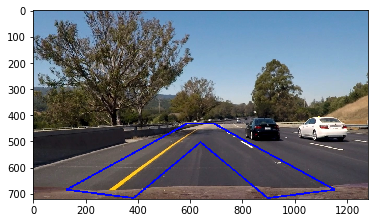

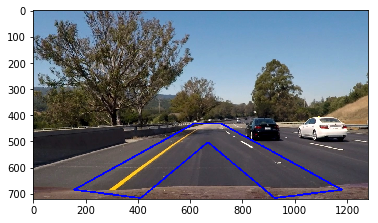

In [15]:
def get_vertices(image, y_top=0.6, x_trim=0.1, x_offset=0, plot=False):
    shape=image.shape
    x_offset /= shape[1]
    vertices = np.array([[(shape[1]*(x_offset+x_trim),shape[0]*0.95),(shape[1]*(x_offset+0.46), shape[0]*y_top),
                          (shape[1]*(x_offset+0.54), shape[0]*y_top),(shape[1]*(x_offset+1-x_trim),shape[0]*0.95),
                          (shape[1]*(x_offset+0.7),shape[0]*0.995), (shape[1]*(x_offset+0.5),shape[0]*0.7),
                          (shape[1]*(x_offset+0.3),shape[0]*0.995)]], dtype=np.int32)
    
    image_plot = draw_trap(image, points=vertices)
    if plot:    
        plt.imshow(image_plot)
        plt.show()
    return vertices, image_plot

ver, with_trap = get_vertices(test_img, plot=True)
ver, with_trap = get_vertices(test_img, x_offset=28, plot=True)

In [22]:
def frame_out(frame):
#     test_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    lanes_img, undist = enhance_lines(frame)
    print(car_location.avg_shift, car_location.recent_position)
    vertices, with_trap = get_vertices(undist, x_offset=car_location.avg_shift)
    
    masked_lanes = apply_mask(lanes_img, vertices)
    
    img_from_top = warp(masked_lanes)
    
    find_lanes(img_from_top)
    
    lines, fits, curvs = [], [], []
    if detected_left_line.has_avgs:
        left_fit, left_curv = detected_left_line.get_avgs()
        left_line = get_line_points(test_img, left_fit)
        lines.append(left_line)
        fits.append(left_fit)
        curvs.append(left_curv)
    if detected_right_line.has_avgs:   
        right_fit, right_curv = detected_right_line.get_avgs()
        right_line = get_line_points(test_img, right_fit)
        lines.append(right_line)
        fits.append(right_fit)
    
    if detected_right_line.has_avgs and detected_right_line.has_avgs:
        lanes = add_lines(test_img, lines)

        result = cv2.addWeighted(undist, 1, lanes, 0.6, 0)

        pix_shift, car_pos_txt = get_car_shift(undist, left_fit, right_fit)

        lane_curv, road_curv_txt = get_curve(left_curv, right_curv)

        result = add_text_to_image(result, car_pos_txt, (350, 100))
        final = add_text_to_image(result, road_curv_txt, (450, 50))
        
        plt.clf()
        plot_pipline(
            [frame, undist, lanes_img, with_trap, masked_lanes, img_from_top, lanes, final],
            ['frame as is', 'undistorted', 'enhanced lines', 'ROI', 'maksed ROI', 
             'top view', 'lanes identified', 'final'])
        
    else:
        final = np.copy(undist)
        car_location.__init__()
    
    return final

creating a new vid with identified lane lines to path:  output_videos/lane_out_project_video.mp4
0 []
car_loc_y:720, car_loc_x:730.8311565451233, img.shape[1]/2:640.0
[[<matplotlib.axes._subplots.AxesSubplot object at 0x11d5fa780>


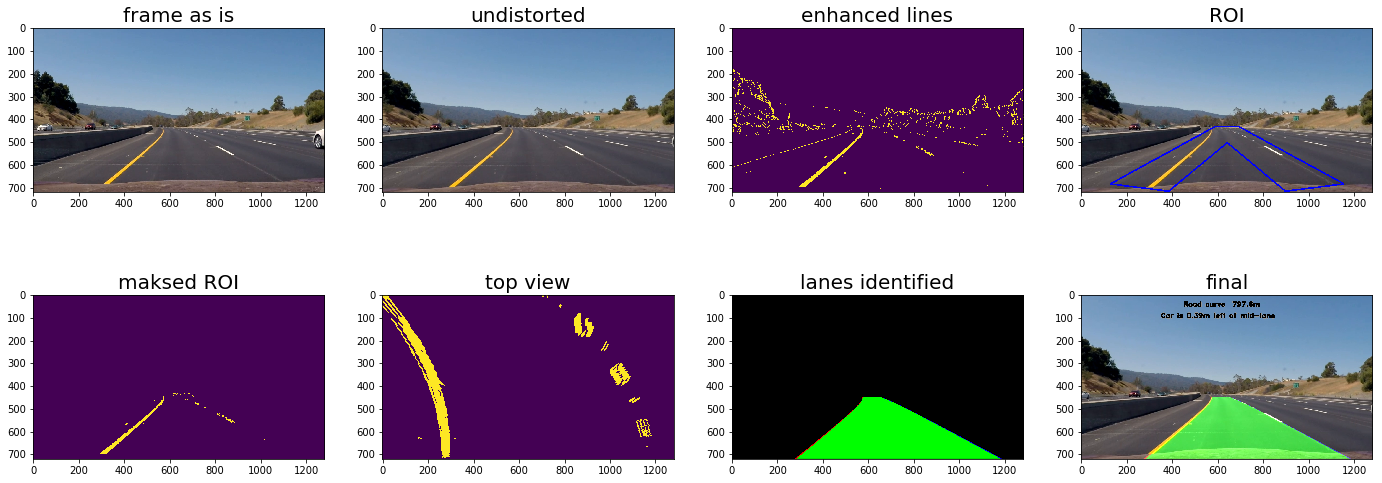

[MoviePy] >>>> Building video output_videos/lane_out_project_video.mp4
[MoviePy] Writing video output_videos/lane_out_project_video.mp4


  0%|          | 0/1 [00:00<?, ?it/s]

27.2493469635 [27.249346963537004]
car_loc_y:720, car_loc_x:731.1596975701269, img.shape[1]/2:640.0
[[<matplotlib.axes._subplots.AxesSubplot object at 0x11e28e358>


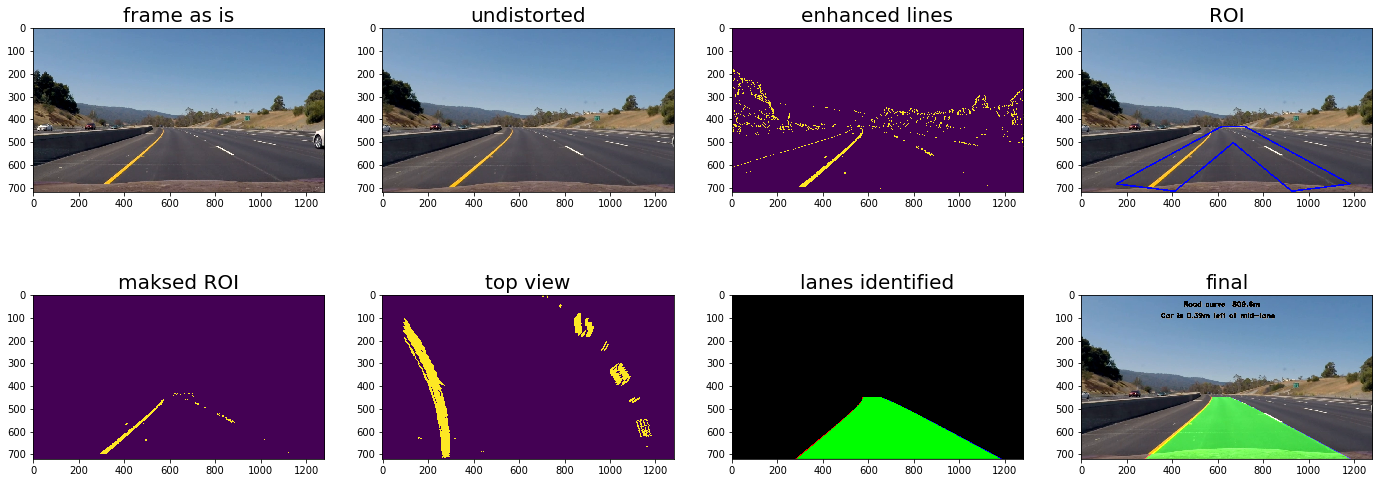

100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lane_out_project_video.mp4 



In [24]:
from moviepy.editor import VideoFileClip
video_files = glob('videos/*.mp4')

output_path = "output_videos/"
for file in video_files[2:]:
    detected_left_line = Line()
    detected_right_line = Line()
    car_location = Car_location()
    output = join(output_path,"lane_out_"+file.split('/')[-1])
    print('creating a new vid with identified lane lines to path: ', output)
    clip2 = VideoFileClip(file)
    challenge_clip = clip2.fl_image(lambda x: frame_out(x))
    challenge_clip.write_videofile(output, audio=False)
